In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from scipy.signal import find_peaks
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
import gffutils
import json

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]


def set_diagonal(pred, val=0):
    l = pred.shape[0]
    idx = np.arange(l)
    pred[idx[:-1], idx[1:]] = val
    pred[idx[1:], idx[:-1]] = val
    
    return pred


def quantile_norm(pred1, pred2):
    l = pred1.shape[0]
    pred1_diag = np.array([np.pad(np.diagonal(pred1, offset=i), (0, i), 'constant') for i in range(200)]).T
    pred2_diag = np.array([np.pad(np.diagonal(pred2, offset=i), (0, i), 'constant') for i in range(200)]).T
    pred = np.column_stack((pred1_diag.ravel(), pred2_diag.ravel()))
    df, df_sorted = pd.DataFrame(pred), pd.DataFrame(np.sort(pred, axis=0))
    df_mean = df_sorted.mean(axis=1)
    df_mean.index += 1
    df_qn = df.rank(method='min').stack().astype(int).map(df_mean).unstack()
    pred1_stripe, pred2_stripe = df_qn[0].values.reshape(-1,200), df_qn[1].values.reshape(-1,200)
    
    pred1_qn, pred2_qn = np.zeros_like(pred1), np.zeros_like(pred2)
    for i in range(200):
        idx = np.arange(l-i, dtype=int)
        pred1_qn[idx, idx+i] = pred1_qn[idx+i, idx] = pred1_stripe[:l-i, i]
        pred2_qn[idx, idx+i] = pred2_qn[idx+i, idx] = pred2_stripe[:l-i, i]
    
    return pred1_qn, pred2_qn


def quantile_norm_multi(preds):
    return


def topdom(mat, size):
    padmat = np.pad(mat, size, mode='constant', constant_values=np.nan)
    dim = padmat.shape[0]
    signal = np.array([
        np.nanmean(padmat[i-size:i+size, i-size:i+size]) for i in range(dim)
    ][size:-size])
    
    return signal


def generate_dim(mindim, maxdim, numdim):
    mindim, maxdim = max(1, mindim), min(100, maxdim)
    return np.linspace(mindim, maxdim, num=numdim, dtype=int)


def get_tads(mat, sizes):
    signal = np.array([topdom(mat, i) for i in tqdm(sizes)])
    rows, idxs = [], []
    for i in range(len(signal)):
        idx = find_peaks(signal[i], prominence=(0.25, ))[0]
        row = np.full_like(idx, i)
        rows.append(row)
        idxs.append(idx)
    tads = np.array([
        np.concatenate(rows, axis=None), np.concatenate(idxs, axis=None)
    ])
    
    return tads


def tads_to_coords(tads, sizes):
    coords = np.array([
        tads[1] - sizes[tads[0]], tads[1] + sizes[tads[0]]
    ])
    
    return coords


def merge_coords(coords, sizes, close=5):
    df = pd.DataFrame({'x': coords[0], 'y': coords[1]})
    merged = df.groupby('x', as_index=False).agg({'y': 'max'})
    merged['s'] = (merged.y - merged.x) // 2
    merged = merged.sort_values(by=['x']).reset_index(drop=True)
    
    i = 0
    curx, cury, curs = merged.iloc[i]
    
    while i+1 < merged.shape[0]:
        x, y, s = merged.iloc[i+1]
        if s == curs:
            if abs(x - curx) <= close:
                curx, cury = min(curx, x), max(cury, y)
                curs = (cury - curx) // 2
                merged = merged.drop(i+1, axis=0).reset_index(drop=True)
            else:
                curx, cury, curs = x, y, s
                i += 1
        else:
            # if abs(s - curs) <= close*2 and (abs(x - curx) <= close or abs(y - cury) <= close):
            if abs(x - curx) <= close or abs(y - cury) <= close:
                curx, cury = min(curx, x), max(cury, y)
                curs = (cury - curx) // 2
                merged = merged.drop(i+1, axis=0).reset_index(drop=True)
            else:
                curx, cury, curs = x, y, s
                i += 1
        merged.iloc[i] = [curx, cury, curs]
    
    return merged.values.T


def get_tad_coords(mat1, mat2, mindim=10, maxdim=100, numdim=10, close=5):
    sizes = generate_dim(mindim, maxdim, numdim)
    tads1, tads2 = get_tads(mat1, sizes), get_tads(mat2, sizes)
    alltads = np.concatenate((tads1, tads2), axis=1)
    allcoords = tads_to_coords(alltads, sizes)
    coords = merge_coords(allcoords, sizes, close)
    
    return coords


def rank_coords(mat1, mat2, coords):
    xs, ys, ss, scores, absscores = [], [], [], [], []
    for i in range(coords.shape[1]):
        x, y, s = coords[:, i]
        area1, area2 = mat1[x:y, x:y], mat2[x:y, x:y]
        area_diff = area1 - area2
        score = np.mean(area_diff)
        absscore = np.std(area_diff) * np.ptp(area_diff)
        xs.append(x)
        ys.append(y)
        ss.append(s)
        scores.append(score)
        absscores.append(absscore)
    df = pd.DataFrame({
        'x_coord': xs, 'y_coord': ys, 'window_size': ss,
        'diff_direction': scores, 'abs_diff_score': absscores
    })
    df = df.sort_values(by=['abs_diff_score'], ignore_index=True, ascending=False)
    
    return df

In [3]:
%%time

chrom = 19
pred_dir = '/data/leslie/suny4/predictions/chromafold/'
ct1 = 'mycGCB_am_gfp_myc_gcb_thelp_sample'
ct2 = 'mycGCB_am_gfp_myc_gcb_nothelp_sample'

pred1 = load_pred(pred_dir, ct1, chrom, avg_stripe=True)
pred2 = load_pred(pred_dir, ct2, chrom, avg_stripe=True)
pred1, pred2 = set_diagonal(pred1), set_diagonal(pred2)
pred1_qn, pred2_qn = quantile_norm(pred1, pred2)

CPU times: user 4.65 s, sys: 2.82 s, total: 7.47 s
Wall time: 8.3 s


In [4]:
coords = get_tad_coords(pred1_qn, pred2_qn, mindim=25, maxdim=75, numdim=10, close=5)
ranked = rank_coords(pred1_qn, pred2_qn, coords)

100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


In [5]:
ranked.head()

,x_coord,y_coord,window_size,diff_direction,abs_diff_score
0,5530,5580,25,0.272760,2.254377
1,2899,3005,53,0.122943,2.081372
2,2893,3010,58,0.123810,1.996191
3,2887,3013,63,0.108776,1.884423
4,2881,3007,63,0.087958,1.870418


In [6]:
ranked.tail()

,x_coord,y_coord,window_size,diff_direction,abs_diff_score
102,1390,1494,52,-0.017166,0.194702
103,1384,1511,63,-0.004142,0.179786
104,1372,1522,75,0.018113,0.177362
105,3094,3181,43,0.051890,0.114527
106,2760,2815,27,0.071681,0.111668


5530, 5580, 25, 0.273, 2.254


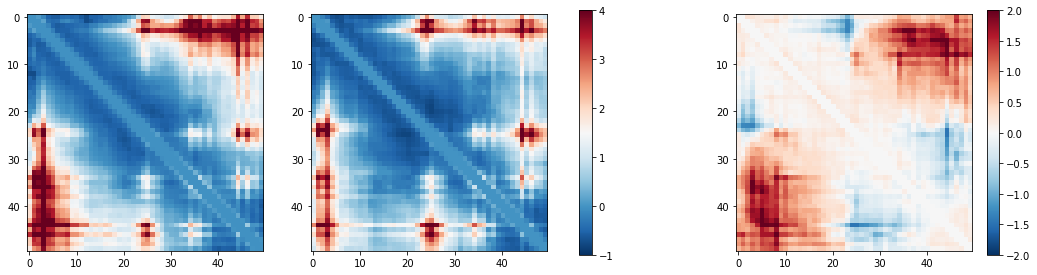

2899, 3005, 53, 0.123, 2.081


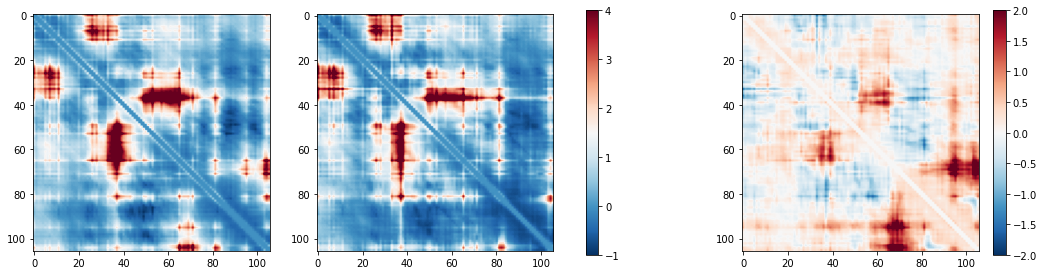

2893, 3010, 58, 0.124, 1.996


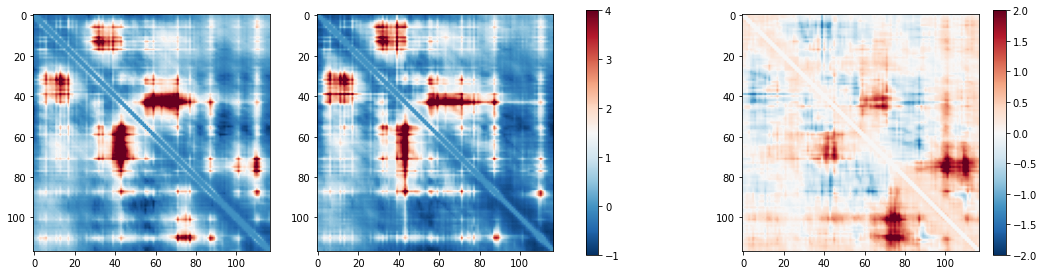

2887, 3013, 63, 0.109, 1.884


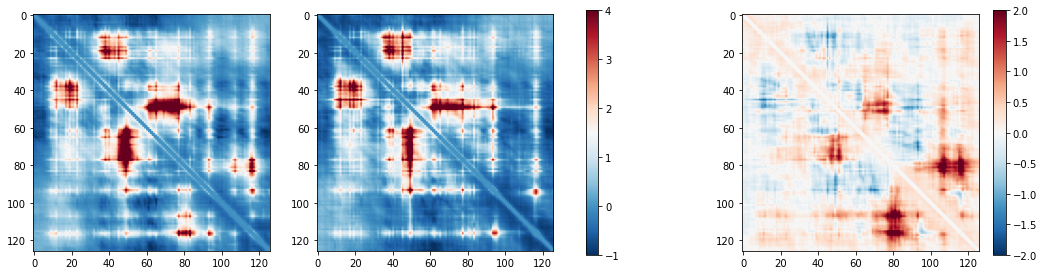

2881, 3007, 63, 0.088, 1.870


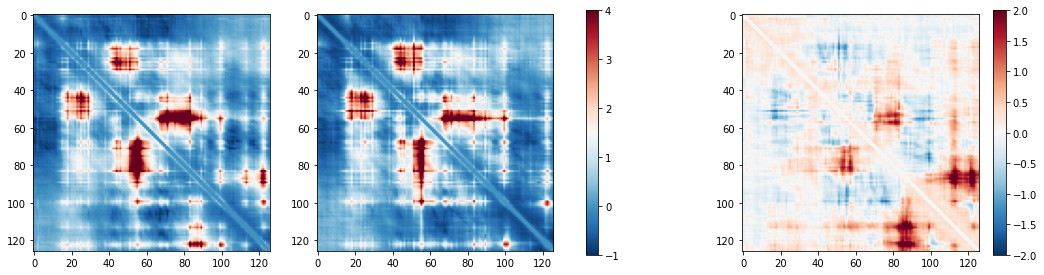

In [7]:
for i in range(5):
    x, y, s, score1, score2 = ranked.iloc[i]
    x, y, s = int(x), int(y), int(s)
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    print(f'{x}, {y}, {s}, %.3f, %.3f' % (score1, score2))
    area1, area2 = pred1_qn[x:y, x:y], pred2_qn[x:y, x:y]
    area_diff = area1 - area2
    im = axs[0].imshow(area1, cmap='RdBu_r', vmax=4, vmin=-1)
    im = axs[1].imshow(area2, cmap='RdBu_r', vmax=4, vmin=-1)
    fig.colorbar(im, ax=axs[:2].ravel().tolist(), shrink=0.75)
    im = axs[2].imshow(area_diff, cmap='RdBu_r', vmax=2, vmin=-2)
    fig.colorbar(im, ax=axs[2], shrink=0.75)
    
    plt.show()

1390, 1494, 52, -0.017, 0.195


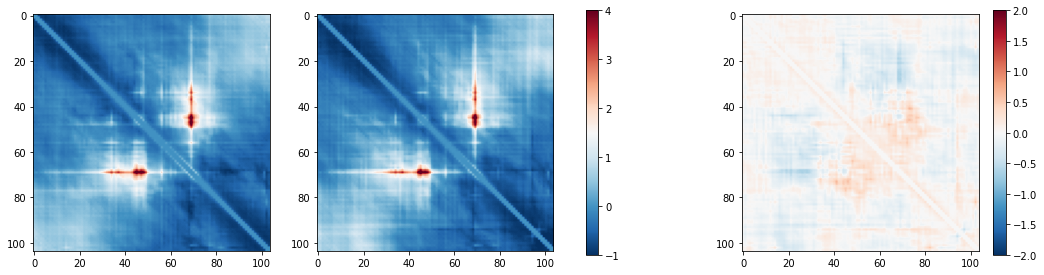

1384, 1511, 63, -0.004, 0.180


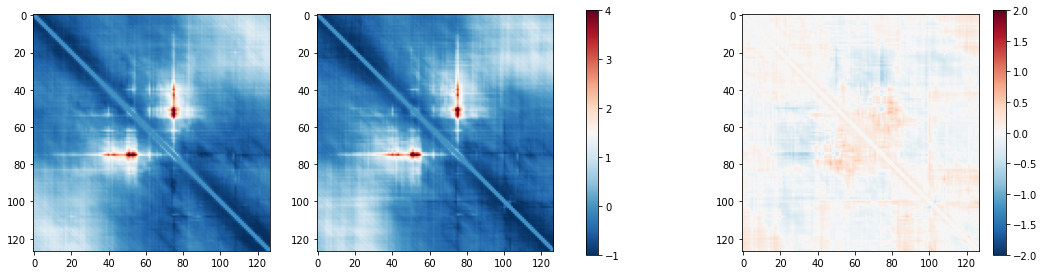

1372, 1522, 75, 0.018, 0.177


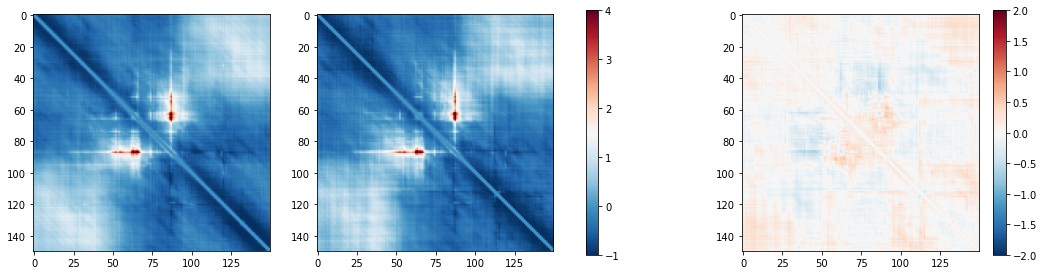

3094, 3181, 43, 0.052, 0.115


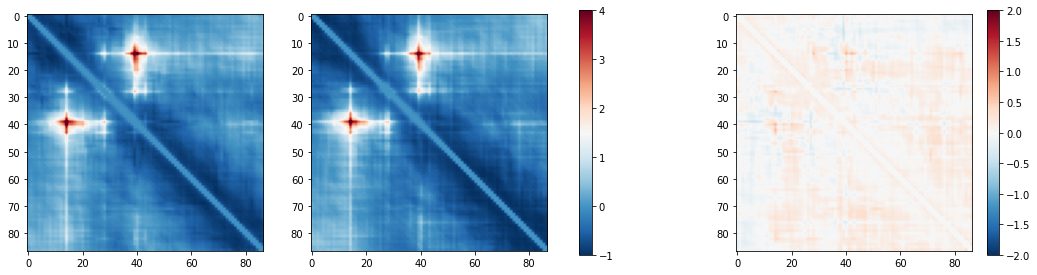

2760, 2815, 27, 0.072, 0.112


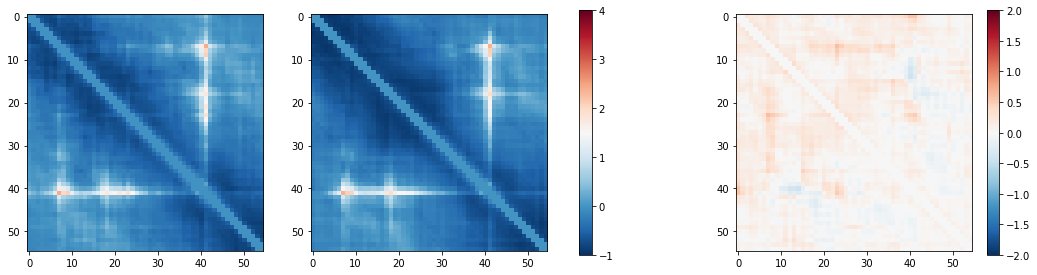

In [8]:
for i in range(-5, 0):
    x, y, s, score1, score2 = ranked.iloc[i]
    x, y, s = int(x), int(y), int(s)
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    print(f'{x}, {y}, {s}, %.3f, %.3f' % (score1, score2))
    area1, area2 = pred1_qn[x:y, x:y], pred2_qn[x:y, x:y]
    area_diff = area1 - area2
    im = axs[0].imshow(area1, cmap='RdBu_r', vmax=4, vmin=-1)
    im = axs[1].imshow(area2, cmap='RdBu_r', vmax=4, vmin=-1)
    fig.colorbar(im, ax=axs[:2].ravel().tolist(), shrink=0.75)
    im = axs[2].imshow(area_diff, cmap='RdBu_r', vmax=2, vmin=-2)
    fig.colorbar(im, ax=axs[2], shrink=0.75)
    
    plt.show()

In [9]:
ranked

,x_coord,y_coord,window_size,diff_direction,abs_diff_score
0,5530,5580,25,0.272760,2.254377
1,2899,3005,53,0.122943,2.081372
2,2893,3010,58,0.123810,1.996191
3,2887,3013,63,0.108776,1.884423
4,2881,3007,63,0.087958,1.870418
...,...,...,...,...,...
102,1390,1494,52,-0.017166,0.194702
103,1384,1511,63,-0.004142,0.179786
104,1372,1522,75,0.018113,0.177362
105,3094,3181,43,0.051890,0.114527


In [138]:
def load_database(db_file, gtf_file):
    if osp.isfile(db_file):
        db = gffutils.FeatureDB(db_file)
    else:
        print('creating db from raw. This might take a while.')
        db = gffutils.create_db(gtf_file, db_file)
    
    return db

db = load_database('/data/leslie/suny4/data/chrom_size/gencode.vM10.basic.annotation.db', None)

In [156]:
ranked['left'] = (ranked.x_coord - 10) * int(1e4)
ranked['right'] = (ranked.y_coord + 10) * int(1e4)
ranked

,x_coord,y_coord,window_size,diff_direction,abs_diff_score,left,right
0,4352,4504,76,-0.024746,3.112053,43420000,45140000
1,4376,4484,54,-0.138940,2.842094,43660000,44940000
2,11172,11300,64,-0.293518,2.689420,111620000,113100000
3,11145,11296,75,-0.258044,2.296200,111350000,113060000
4,11225,11300,37,-0.440322,2.213770,112150000,113100000
...,...,...,...,...,...,...,...
78,11021,11095,37,-0.030320,0.260407,110110000,111050000
79,5783,5910,63,-0.016211,0.249126,57730000,59200000
80,642,693,25,0.032197,0.216049,6320000,7030000
81,8145,8195,25,-0.084440,0.166823,81350000,82050000


In [165]:
i = 0
x, y, s, diff_dir, abs_score, left, right = ranked.iloc[i]
line1 = 'select * from features where'
line2 = f'start >= {left} and start <= {right}'
line3 = f'end >= {left} and end <= {right}'
line4 = f'end - start >= 1000 and seqid = \"chr13\" and featuretype = \"gene\"'
query = f'{line1} {line2} and {line3} and {line4}'

chrom, start, end, attrs = [], [], [], []
valid = 0
itr = db.execute(query).fetchall()
for obj in itr:
    attr = json.loads(obj['attributes'])
    chrom.append(obj['seqid'])
    start.append(obj['start'])
    end.append(obj['end'])
    attrs.append(attr)
    valid += 1
    
    
def merge_attr(attrs):
    if not attrs:
        raise ValueError(
            'No attributes detected. Please consider expanding your search by changing the filters'
        )
    return {k: [attr[k][0] if k in attr else None for attr in attrs] for k in attrs[0].keys()}


get_cols = ['chrom', 'start', 'end', 'gene_name', 'gene_id', 'gene_type', 'level', 'diff_direction', 'abs_diff_score']

if valid:
    info = pd.DataFrame({
        'chrom': chrom, 'start': start, 'end': end
    })
    attrs = pd.DataFrame(merge_attr(attrs))
    res = pd.concat([info, attrs], axis=1)
    res['diff_direction'] = diff_dir
    res['abs_diff_score'] = abs_score
    res = res[get_cols]

res

,chrom,start,end,gene_name,gene_id,gene_type,level,diff_direction,abs_diff_score
0,chr13,43538412,43560191,Mcur1,ENSMUSG00000021371.4,protein_coding,3,-0.024746,3.112053
1,chr13,43615710,43670945,Rnf182,ENSMUSG00000044164.2,protein_coding,2,-0.024746,3.112053
2,chr13,43716791,43719038,RP24-156M16.2,ENSMUSG00000110016.1,lincRNA,2,-0.024746,3.112053
3,chr13,43785107,43803130,Cd83,ENSMUSG00000015396.3,protein_coding,3,-0.024746,3.112053
4,chr13,44121167,44125179,Gm5083,ENSMUSG00000089815.7,lincRNA,2,-0.024746,3.112053
5,chr13,44400436,44455303,Gm27007,ENSMUSG00000098107.1,lincRNA,2,-0.024746,3.112053
6,chr13,44439712,44457569,1700029N11Rik,ENSMUSG00000098144.7,lincRNA,2,-0.024746,3.112053
7,chr13,44729474,44921643,Jarid2,ENSMUSG00000038518.15,protein_coding,2,-0.024746,3.112053
8,chr13,44922079,45002096,Dtnbp1,ENSMUSG00000057531.13,protein_coding,3,-0.024746,3.112053
9,chr13,45078692,45081222,Gm9817,ENSMUSG00000047061.6,protein_coding,3,-0.024746,3.112053
